In [1]:
## install git and configure(so we know who commit the code)
# !apt-get install git
# !git config --global user.name "USER_NAME"
# !git config --global user.email "EMAIL"

# access google drive
# from google.colab import drive
# drive.mount('/content/drive')

# clone repo
!git clone https://github.com/Mu-niu13/Image-Translation-CycleGAN.git
%cd Image-Translation-CycleGAN

# set up personal access for push/pull
from getpass import getpass
token = getpass('Enter your GitHub PAT:')
!git remote set-url origin https://{token}@github.com/Mu-niu13/Image-Translation-CycleGAN.git

Cloning into 'Image-Translation-CycleGAN'...
remote: Enumerating objects: 1228, done.
remote: Counting objects: 100% (1228/1228), done.
remote: Compressing objects: 100% (1222/1222), done.
remote: Total 1228 (delta 7), reused 1215 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (1228/1228), 35.10 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/Image-Translation-CycleGAN
Enter your GitHub PAT:··········


=== Training at resolution 16x16 ===


100%|██████████| 170M/170M [00:25<00:00, 6.60MB/s]


Extracting ./data/cifar/cifar-10-python.tar.gz to ./data/cifar


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


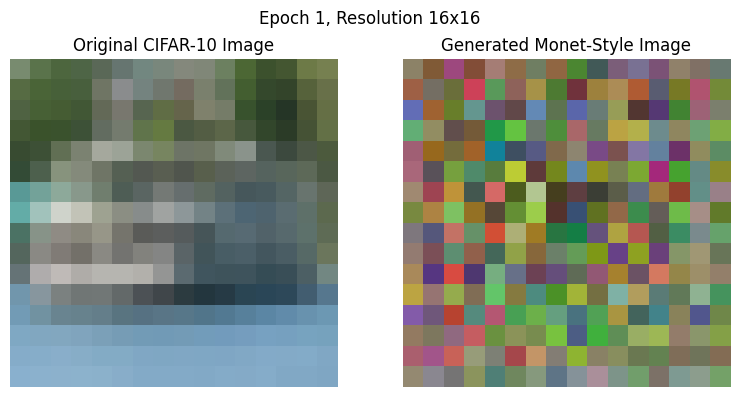

Epoch 1/3 | G Loss: 2.5371 | D Loss: 0.2442


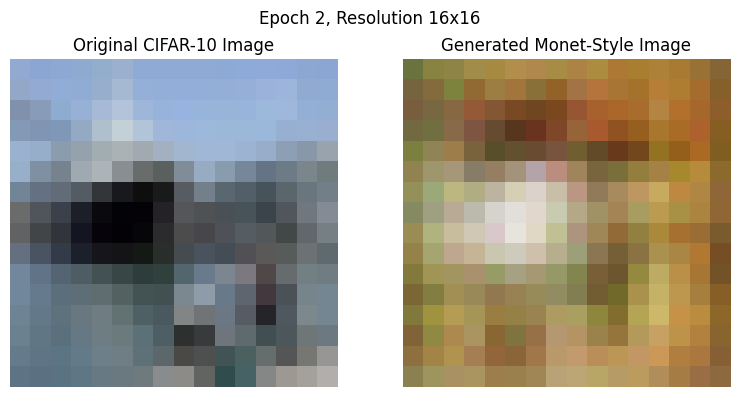

Epoch 2/3 | G Loss: 1.9374 | D Loss: 0.2227


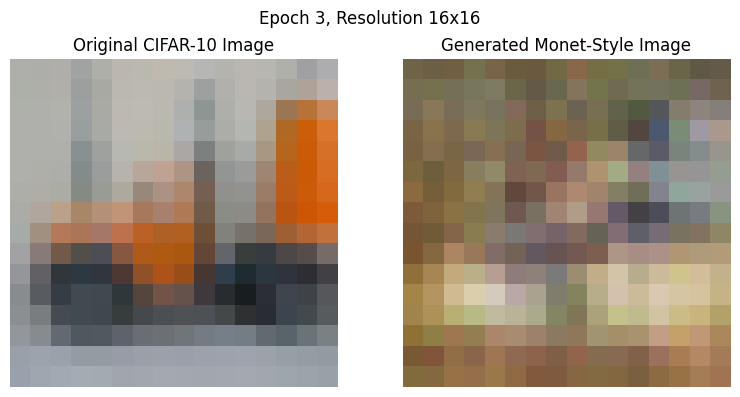

Epoch 3/3 | G Loss: 1.8541 | D Loss: 0.2173
=== Training at resolution 32x32 ===
Files already downloaded and verified


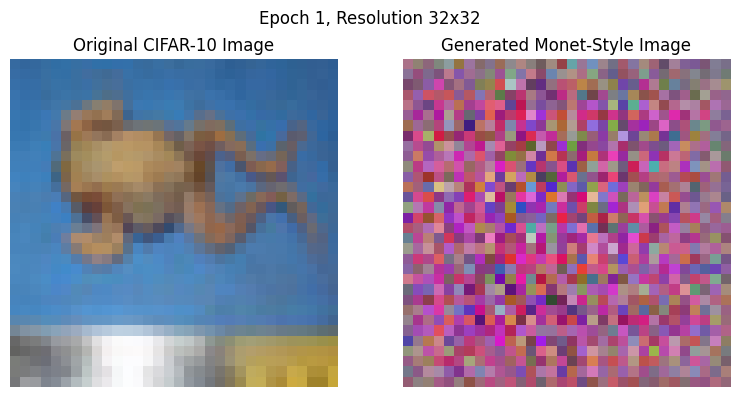

Epoch 1/3 | G Loss: 2.1437 | D Loss: 0.2456


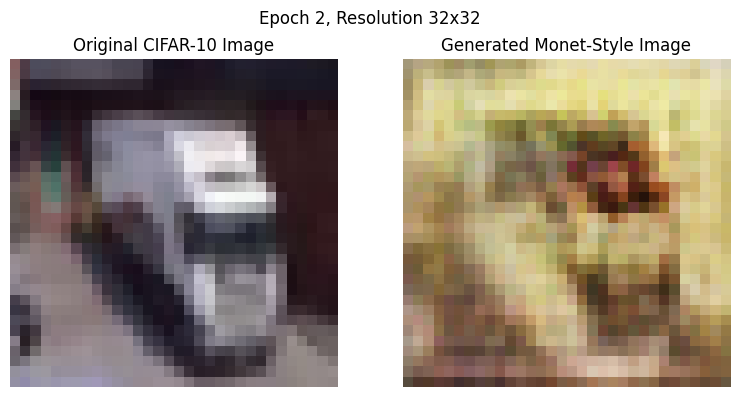

Epoch 2/3 | G Loss: 1.6087 | D Loss: 0.2257


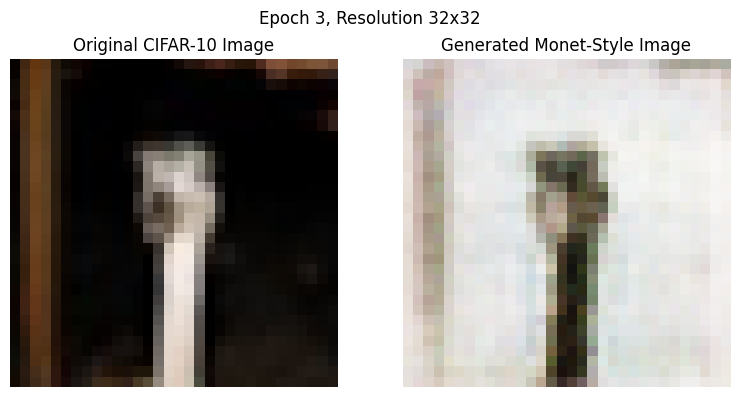

Epoch 3/3 | G Loss: 1.4444 | D Loss: 0.2211
=== Training at resolution 64x64 ===
Files already downloaded and verified


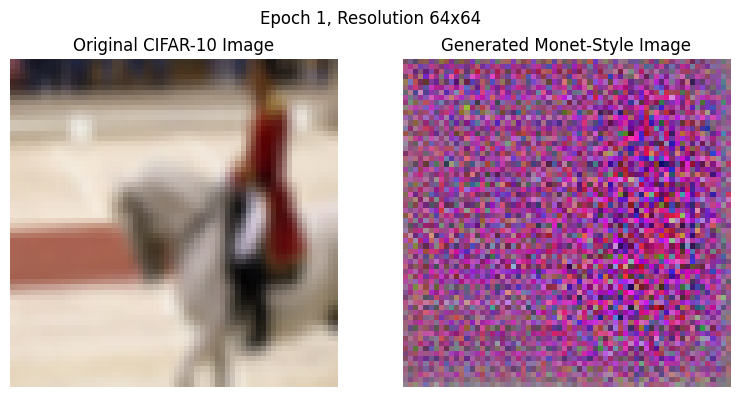

Epoch 1/3 | G Loss: 1.7863 | D Loss: 0.2210


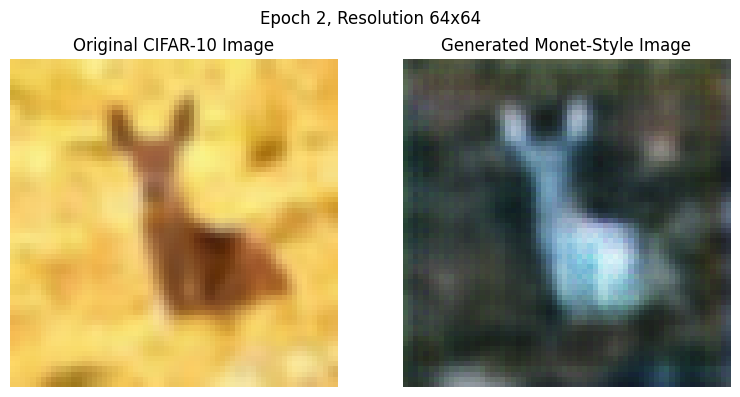

Epoch 2/3 | G Loss: 1.3104 | D Loss: 0.2056


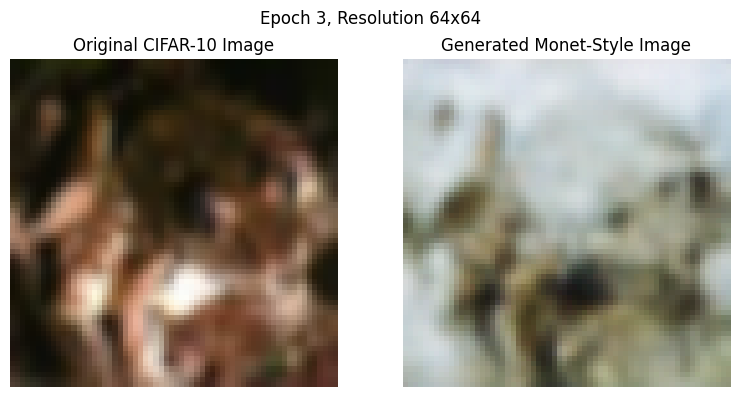

Epoch 3/3 | G Loss: 1.2271 | D Loss: 0.1848


In [6]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import torchvision

from tqdm import tqdm
from scipy.linalg import sqrtm

###############################################
# Utility Functions for Metrics (FID)
###############################################

def inception_forward(x, inception_model):
    with torch.no_grad():
        if x.size(2) < 75 or x.size(3) < 75:
            x = nn.functional.interpolate(x, size=(75, 75), mode='bilinear', align_corners=False)
        features = inception_model.forward(x)
    return features['logits'], features['pool3']

def calculate_activation_statistics(images, inception_model, batch_size=32, device='cuda'):
    inception_model.eval()
    n = images.size(0)
    preds = []

    for i in range(0, n, batch_size):
        batch = images[i:i+batch_size].to(device)
        _, pool3 = inception_forward(batch, inception_model)
        preds.append(pool3.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    mu = np.mean(preds, axis=0)
    sigma = np.cov(preds, rowvar=False)
    return mu, sigma

def calculate_fid(real_images, generated_images, inception_model, device='cuda'):
    mu_real, sigma_real = calculate_activation_statistics(real_images, inception_model, device=device)
    mu_gen, sigma_gen = calculate_activation_statistics(generated_images, inception_model, device=device)

    diff = mu_real - mu_gen
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

###############################################
# Dataset Classes
###############################################

class MonetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.files = glob.glob(os.path.join(root, '*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

###############################################
# CycleGAN Networks
###############################################

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_res_blocks=6):
        super(Generator, self).__init__()
        model = [nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3), nn.InstanceNorm2d(ngf), nn.ReLU(inplace=True)]

        # Downsampling
        n_down = 2
        for i in range(n_down):
            mult = 2**i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(inplace=True)
            ]

        # Residual blocks
        mult = 2**n_down
        for _ in range(n_res_blocks):
            model += [ResidualBlock(ngf * mult)]

        # Upsampling
        for i in range(n_down):
            mult = 2**(n_down - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(inplace=True)
            ]

        # Final layer
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=3), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, kernel_size=4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

###############################################
# Loss Functions
###############################################

def cycle_consistency_loss(x, reconstructed_x, lambda_cycle=10.0):
    return lambda_cycle * torch.mean(torch.abs(x - reconstructed_x))

def gan_loss(pred, target_is_real=True):
    target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
    return torch.mean((pred - target)**2)

###############################################
# Main Training Loop
###############################################

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    root_cifar = './data/cifar'
    root_monet = './data/monet'

    resolutions = [16, 32, 64]
    epochs_per_stage = 3
    batch_size = 32
    lr = 0.0002
    beta1, beta2 = 0.5, 0.999

    for resolution in resolutions:
        print(f"=== Training at resolution {resolution}x{resolution} ===")
        transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # Load CIFAR-10 and Monet datasets
        cifar_dataset = torchvision.datasets.CIFAR10(root=root_cifar, train=True, download=True, transform=transform)
        monet_dataset = MonetDataset(root=root_monet, transform=transform)

        cifar_loader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
        monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

        G = Generator(3, 3).to(device)
        Dy = Discriminator(3).to(device)

        optim_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
        optim_D = optim.Adam(Dy.parameters(), lr=lr, betas=(beta1, beta2))

        for epoch in range(epochs_per_stage):
            G.train()
            Dy.train()

            epoch_loss_G = 0.0
            epoch_loss_D = 0.0

            for i, (cifar_images, _) in enumerate(cifar_loader):
                cifar_images = cifar_images.to(device)

                # Train Generator
                optim_G.zero_grad()
                fake_monet = G(cifar_images)
                cycle_cifar = G(fake_monet)

                loss_cycle = cycle_consistency_loss(cifar_images, cycle_cifar)
                pred_fake = Dy(fake_monet)
                loss_g_adv = gan_loss(pred_fake, True)

                loss_G = loss_g_adv + loss_cycle
                loss_G.backward()
                optim_G.step()

                # Train Discriminator
                optim_D.zero_grad()
                pred_real = Dy(cifar_images)
                pred_fake = Dy(fake_monet.detach())
                loss_D = (gan_loss(pred_real, True) + gan_loss(pred_fake, False)) * 0.5
                loss_D.backward()
                optim_D.step()

                epoch_loss_G += loss_G.item()
                epoch_loss_D += loss_D.item()

                # Save and Display First Image Pair of the First Batch
                if i == 0:  # Only for the first batch
                    original_image = cifar_images[0].detach().cpu()
                    generated_image = fake_monet[0].detach().cpu()

                    # Denormalize images for visualization
                    def denormalize(img):
                        return img * 0.5 + 0.5

                    original_image = denormalize(original_image).permute(1, 2, 0).numpy()
                    generated_image = denormalize(generated_image).permute(1, 2, 0).numpy()

                    # Save and display images
                    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
                    axes[0].imshow(np.clip(original_image, 0, 1))
                    axes[0].set_title('Original CIFAR-10 Image')
                    axes[0].axis('off')

                    axes[1].imshow(np.clip(generated_image, 0, 1))
                    axes[1].set_title('Generated Monet-Style Image')
                    axes[1].axis('off')

                    plt.suptitle(f"Epoch {epoch+1}, Resolution {resolution}x{resolution}")
                    plt.tight_layout()
                    plt.show()

            print(f"Epoch {epoch+1}/{epochs_per_stage} | G Loss: {epoch_loss_G/len(cifar_loader):.4f} | "
                  f"D Loss: {epoch_loss_D/len(cifar_loader):.4f}")

=== Training at resolution 32x32 ===
Files already downloaded and verified


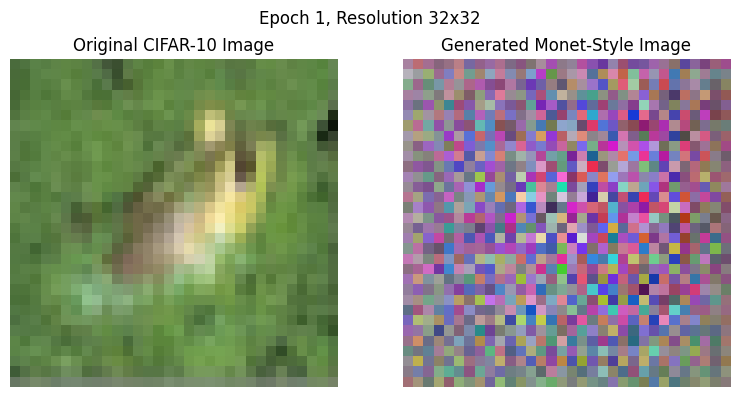

Epoch 1/3 | G Loss: 0.2552 | D Loss: 0.0165


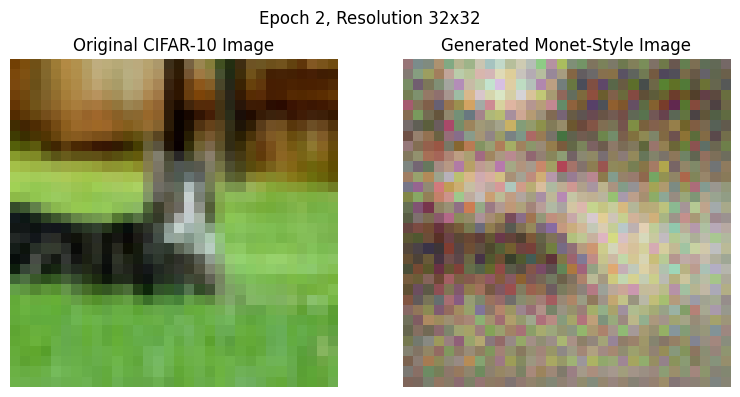

Epoch 2/3 | G Loss: 0.2115 | D Loss: 0.0111


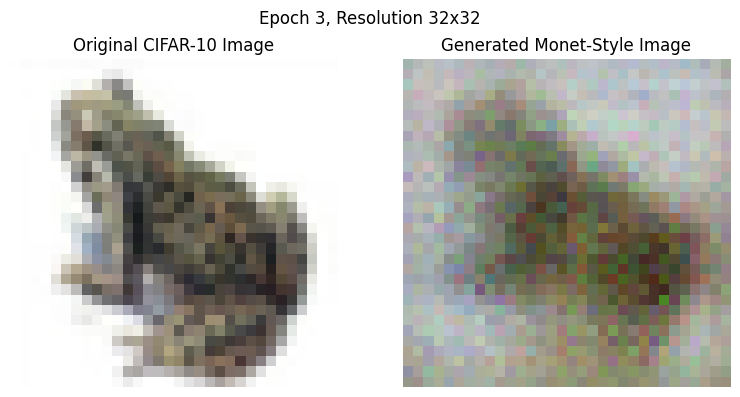

Epoch 3/3 | G Loss: 0.1897 | D Loss: 0.0112
=== Training at resolution 64x64 ===
Files already downloaded and verified


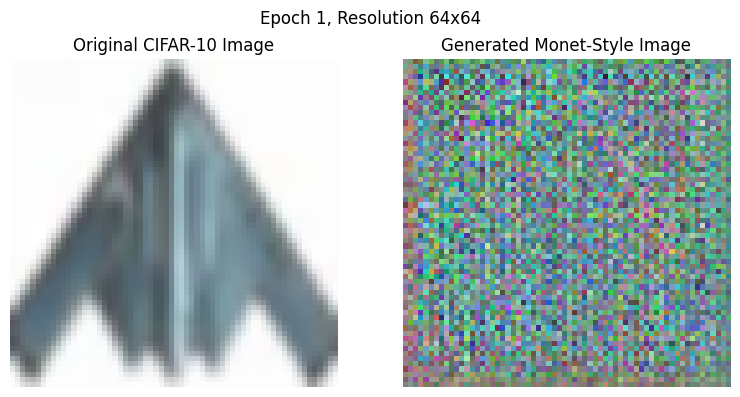

Epoch 1/3 | G Loss: 0.2293 | D Loss: 0.0138


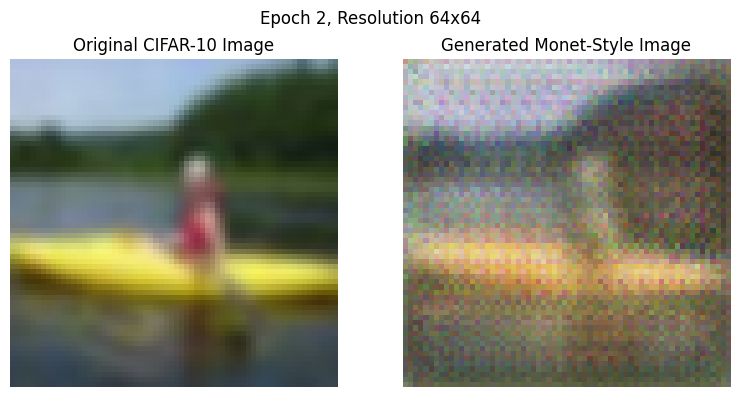

Epoch 2/3 | G Loss: 0.1892 | D Loss: 0.0109


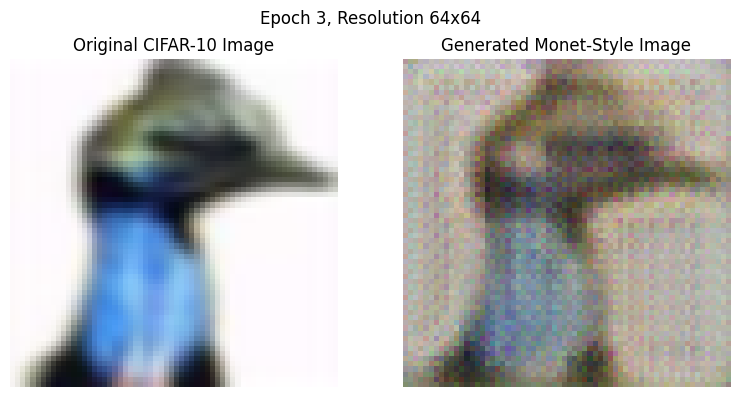

Epoch 3/3 | G Loss: 0.1687 | D Loss: 0.0109
=== Training at resolution 128x128 ===
Files already downloaded and verified


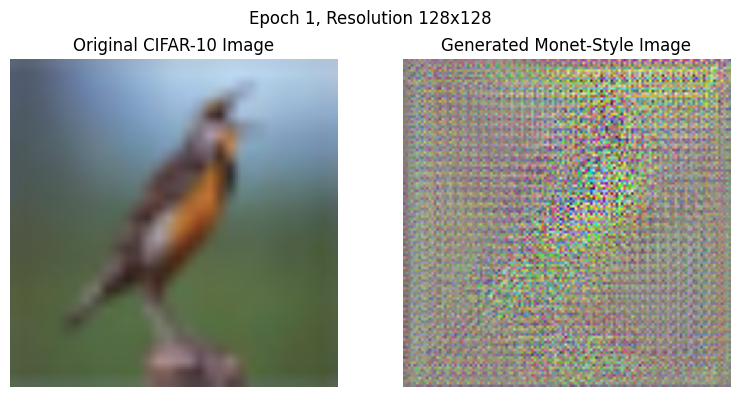

Epoch 1/3 | G Loss: 0.2163 | D Loss: 0.0144


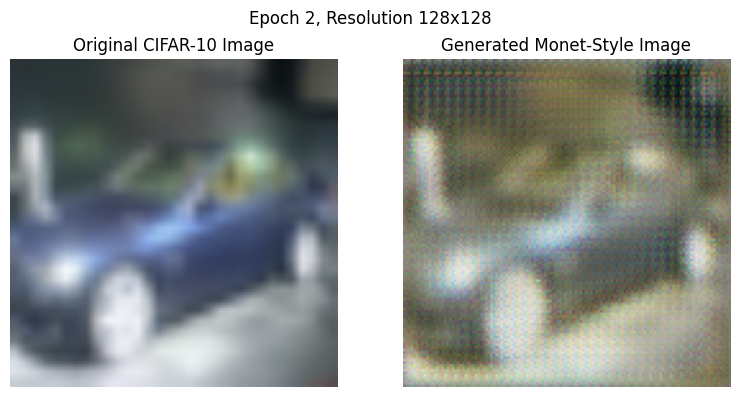

Epoch 2/3 | G Loss: 0.1867 | D Loss: 0.0109


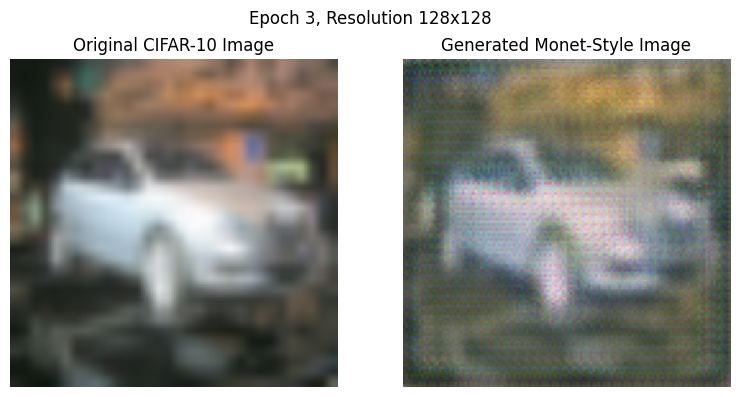

Epoch 3/3 | G Loss: 0.1738 | D Loss: 0.0108
=== Training at resolution 256x256 ===
Files already downloaded and verified


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 275.06 MiB is free. Process 3113 has 14.48 GiB memory in use. Of the allocated memory 13.05 GiB is allocated by PyTorch, and 1.30 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import torchvision

from tqdm import tqdm
from scipy.linalg import sqrtm

###############################################
# Utility Functions for Metrics (FID)
###############################################

def inception_forward(x, inception_model):
    with torch.no_grad():
        if x.size(2) < 75 or x.size(3) < 75:
            x = nn.functional.interpolate(x, size=(75, 75), mode='bilinear', align_corners=False)
        features = inception_model.forward(x)
    return features['logits'], features['pool3']

def calculate_activation_statistics(images, inception_model, batch_size=32, device='cuda'):
    inception_model.eval()
    n = images.size(0)
    preds = []

    for i in range(0, n, batch_size):
        batch = images[i:i+batch_size].to(device)
        _, pool3 = inception_forward(batch, inception_model)
        preds.append(pool3.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    mu = np.mean(preds, axis=0)
    sigma = np.cov(preds, rowvar=False)
    return mu, sigma

def calculate_fid(real_images, generated_images, inception_model, device='cuda'):
    mu_real, sigma_real = calculate_activation_statistics(real_images, inception_model, device=device)
    mu_gen, sigma_gen = calculate_activation_statistics(generated_images, inception_model, device=device)

    diff = mu_real - mu_gen
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

###############################################
# Dataset Classes
###############################################

class MonetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.files = glob.glob(os.path.join(root, '*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

###############################################
# CycleGAN Networks
###############################################

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_res_blocks=6):
        super(Generator, self).__init__()
        model = [nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3), nn.InstanceNorm2d(ngf), nn.ReLU(inplace=True)]

        # Downsampling
        n_down = 2
        for i in range(n_down):
            mult = 2**i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(inplace=True)
            ]

        # Residual blocks
        mult = 2**n_down
        for _ in range(n_res_blocks):
            model += [ResidualBlock(ngf * mult)]

        # Upsampling
        for i in range(n_down):
            mult = 2**(n_down - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(inplace=True)
            ]

        # Final layer
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=3), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, kernel_size=4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

###############################################
# Loss Functions
###############################################

def cycle_consistency_loss(x, reconstructed_x, lambda_cycle=10.0):
    """Cycle consistency loss to ensure translation is invertible."""
    return lambda_cycle * torch.mean(torch.abs(x - reconstructed_x))

def identity_loss(x, identity_x, lambda_identity=5.0):
    """Identity loss to ensure color and texture consistency."""
    return lambda_identity * torch.mean(torch.abs(x - identity_x))

def gan_loss(pred, target_is_real=True):
    """Adversarial loss to distinguish between real and fake images."""
    target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
    return torch.mean((pred - target)**2)

###############################################
# Main Training Loop
###############################################

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    root_cifar = './data/cifar'
    root_monet = './data/monet'

    resolutions = [32, 64, 128, 256, 512, 1024]
    epochs_per_stage = 3
    batch_size = 32
    lr = 0.0002
    beta1, beta2 = 0.5, 0.999

    lambda_cycle = 10.0
    lambda_identity = 5.0

    for resolution in resolutions:
        print(f"=== Training at resolution {resolution}x{resolution} ===")
        transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # Load CIFAR-10 and Monet datasets
        cifar_dataset = torchvision.datasets.CIFAR10(root=root_cifar, train=True, download=True, transform=transform)
        monet_dataset = MonetDataset(root=root_monet, transform=transform)

        cifar_loader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
        monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

        # Initialize models
        G_AtoB = Generator(3, 3).to(device)
        G_BtoA = Generator(3, 3).to(device)
        D_A = Discriminator(3).to(device)
        D_B = Discriminator(3).to(device)

        # Optimizers
        optim_G = optim.Adam(list(G_AtoB.parameters()) + list(G_BtoA.parameters()), lr=lr, betas=(beta1, beta2))
        optim_D = optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=lr, betas=(beta1, beta2))

        # We'll iterate over both datasets in parallel
        # Note: zip stops at the shortest iterator, ensure both have the same length or handle accordingly
        for epoch in range(epochs_per_stage):
            G_AtoB.train()
            G_BtoA.train()
            D_A.train()
            D_B.train()

            epoch_loss_G = 0.0
            epoch_loss_D = 0.0

            for i, ((cifar_images, _), monet_images) in enumerate(zip(cifar_loader, monet_loader)):
                cifar_images = cifar_images.to(device)
                monet_images = monet_images.to(device)

                # Step 1: Train Generators
                optim_G.zero_grad()

                # A->B->A cycle
                fake_monet = G_AtoB(cifar_images)      # CIFAR to Monet
                cycle_cifar = G_BtoA(fake_monet)       # Monet back to CIFAR

                # B->A->B cycle
                fake_cifar = G_BtoA(monet_images)      # Monet to CIFAR
                cycle_monet = G_AtoB(fake_cifar)       # CIFAR back to Monet

                # Identity passes (to encourage generators to not change images of the target domain)
                identity_monet = G_AtoB(monet_images)  # Monet image through AtoB (should remain Monet)
                identity_cifar = G_BtoA(cifar_images)   # CIFAR image through BtoA (should remain CIFAR)

                # Compute Generator Losses
                loss_gan_AtoB = gan_loss(D_B(fake_monet), True)   # fool D_B with fake_monet
                loss_gan_BtoA = gan_loss(D_A(fake_cifar), True)   # fool D_A with fake_cifar

                loss_cycle_A = cycle_consistency_loss(cifar_images, cycle_cifar, lambda_cycle)
                loss_cycle_B = cycle_consistency_loss(monet_images, cycle_monet, lambda_cycle)

                loss_identity_A = identity_loss(monet_images, identity_monet, lambda_identity)
                loss_identity_B = identity_loss(cifar_images, identity_cifar, lambda_identity)

                # Total Generator Loss
                loss_G = (
                    loss_gan_AtoB +
                    loss_gan_BtoA +
                    loss_cycle_A +
                    loss_cycle_B +
                    loss_identity_A +
                    loss_identity_B
                )
                loss_G.backward()
                optim_G.step()

                # Step 2: Train Discriminators
                optim_D.zero_grad()

                # Detach fake images for discriminator training
                fake_cifar_detached = fake_cifar.detach()
                fake_monet_detached = fake_monet.detach()

                # Discriminator A (distinguish real CIFAR from fake CIFAR)
                pred_real_A = D_A(cifar_images)
                pred_fake_A = D_A(fake_cifar_detached)
                loss_D_A = (gan_loss(pred_real_A, True) + gan_loss(pred_fake_A, False)) * 0.5

                loss_D_A.backward(retain_graph=True)

                # Discriminator B (distinguish real Monet from fake Monet)
                pred_real_B = D_B(monet_images)
                pred_fake_B = D_B(fake_monet_detached)
                loss_D_B = (gan_loss(pred_real_B, True) + gan_loss(pred_fake_B, False)) * 0.5

                loss_D_B.backward()

                # Step the optimizer
                optim_D.step()

                # Combine D losses
                loss_D = loss_D_A + loss_D_B

                epoch_loss_G += loss_G.item()
                epoch_loss_D += loss_D.item()

                # Save and Display First Image Pair of the First Batch
                if i == 0:  # Only for the first batch in each epoch
                    def denormalize(img):
                        return img * 0.5 + 0.5

                    original_image = cifar_images[0].detach().cpu()
                    generated_image = fake_monet[0].detach().cpu()

                    original_image = denormalize(original_image).permute(1, 2, 0).numpy()
                    generated_image = denormalize(generated_image).permute(1, 2, 0).numpy()

                    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
                    axes[0].imshow(np.clip(original_image, 0, 1))
                    axes[0].set_title('Original CIFAR-10 Image')
                    axes[0].axis('off')

                    axes[1].imshow(np.clip(generated_image, 0, 1))
                    axes[1].set_title('Generated Monet-Style Image')
                    axes[1].axis('off')

                    plt.suptitle(f"Epoch {epoch+1}, Resolution {resolution}x{resolution}")
                    plt.tight_layout()
                    plt.show()

            print(f"Epoch {epoch+1}/{epochs_per_stage} | G Loss: {epoch_loss_G/len(cifar_loader):.4f} | "
                  f"D Loss: {epoch_loss_D/len(cifar_loader):.4f}")